In [ ]:
from astropy.io import fits
import numpy as np
import os
import matplotlib.pyplot as plt
from astropy.stats import SigmaClip
from photutils.background import Background2D, SExtractorBackground
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from scipy import ndimage
from scipy.ndimage import gaussian_filter
import little_things_functions as ltf
import cv2
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from matplotlib.colors import Normalize
from matplotlib import cm
from scipy.fft import fft2, fftshift

# DDO 101

(705, 681)


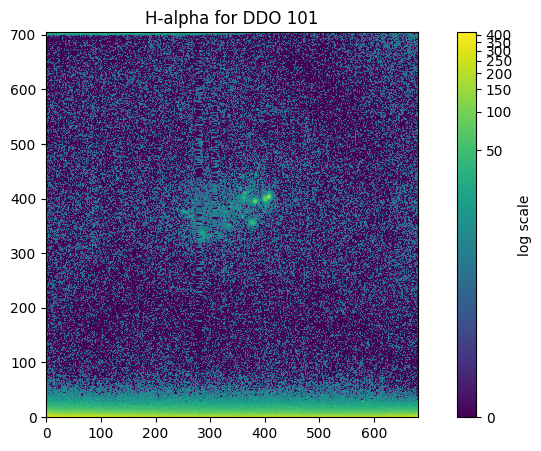

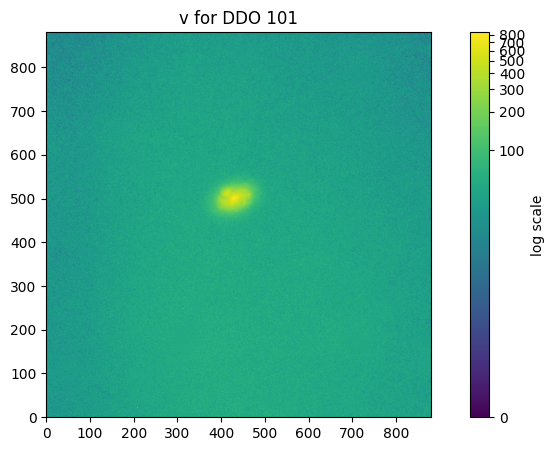

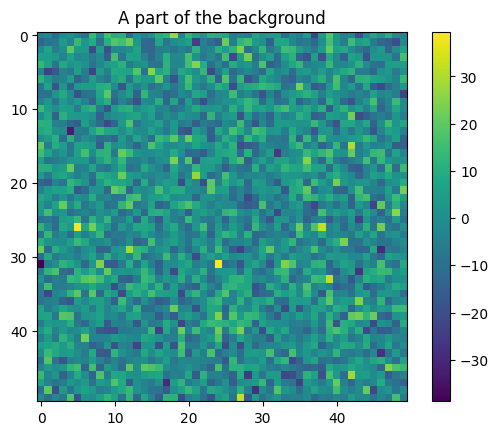

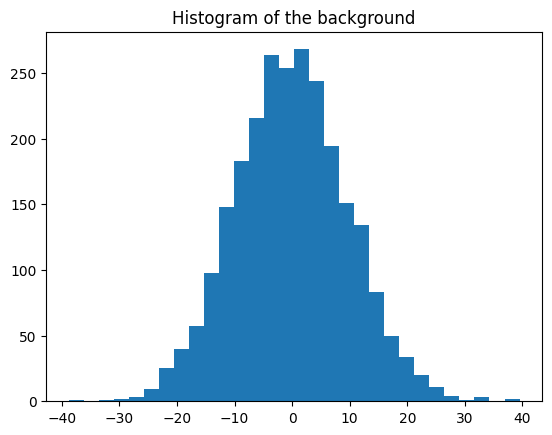

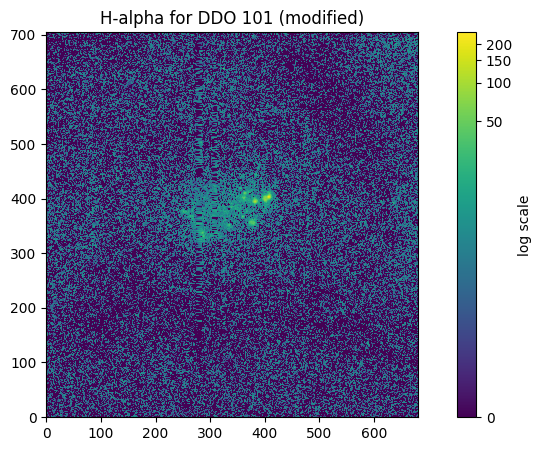

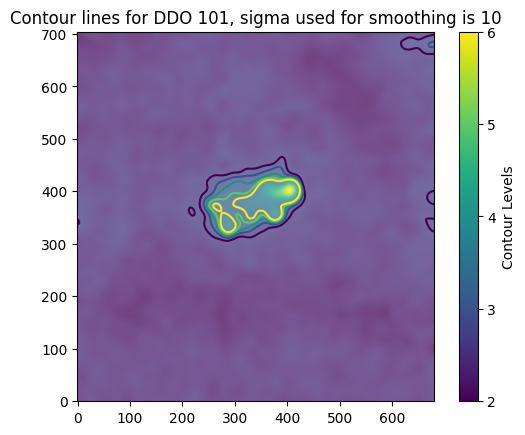

In [2]:
galaxy_name = "DDO 101"
DDO101_H = ltf.open_fits(r"C:\Users\AYSAN\Desktop\project\Galaxy\Data\DDO 101\d101hmrms.fits")
DDO101_V = ltf.open_fits(r"C:\Users\AYSAN\Desktop\project\Galaxy\Starless images\d101\starless_backgroundless_d101v_aligned.fits.fit")
print(np.shape(DDO101_H))
# Trim the image
DDO101_H_trimmed = DDO101_H[80: -10]
ltf.log_scale_plot(DDO101_H, f"H-alpha for {galaxy_name}", "log scale")
ltf.log_scale_plot(DDO101_V, f"v for {galaxy_name}", "log scale")

# Generate the replacement values from a normal distribution
chunk = DDO101_H[100:150, 400:450]
mean = np.mean(chunk)
std_dev = np.std(chunk)

# Create a full array with replacement values
DDO101_H_replaced = np.random.normal(loc=mean, scale=std_dev, size=DDO101_H.shape)

# Copy the trimmed portion back into the original image shape
DDO101_H_replaced[80:-10, :] = DDO101_H_trimmed

# For visual confirmation, plot the chunk histogram
plt.imshow(chunk)
plt.title("A part of the background")
plt.colorbar()
plt.show()
plt.hist(chunk.flatten(), bins=30)
plt.title("Histogram of the background")
plt.show()
# Plot the modified data
ltf.log_scale_plot(DDO101_H_replaced, f"H-alpha for {galaxy_name} (modified)", "log scale")

sigma = 10

# Assuming DDO101_H_replaced is already defined
smoothed = gaussian_filter(DDO101_H_replaced, sigma)

fig, ax = plt.subplots()
im = ax.imshow(smoothed, alpha=0.75, origin="lower")

# Create the contour plot
levels = [2, 3, 4, 5, 6]
CS = ax.contour(smoothed, levels, cmap='viridis')

# Create a custom color bar for the contour lines
norm = Normalize(vmin=2, vmax=6)  # Adjust this range according to your contour levels
sm = cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])

# Add the color bar with labels
cbar = fig.colorbar(sm, ax=ax, ticks=levels)
cbar.ax.set_yticklabels([str(level) for level in levels])
cbar.set_label('Contour Levels')

plt.title(f"Contour lines for {galaxy_name}, sigma used for smoothing is {sigma}")
plt.show()




# Resolution DDO 101

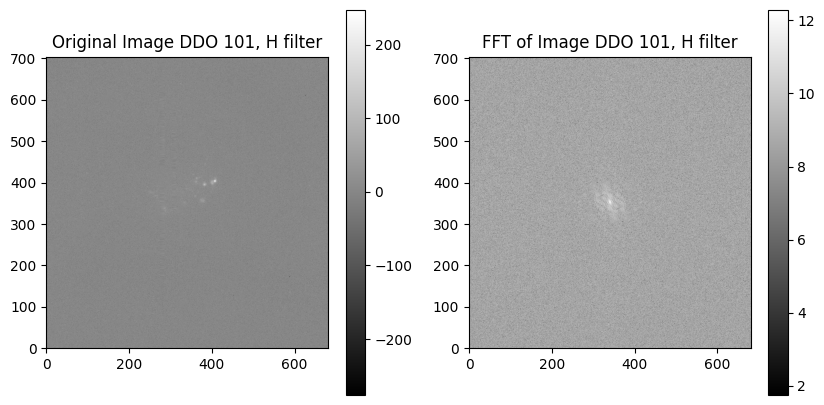

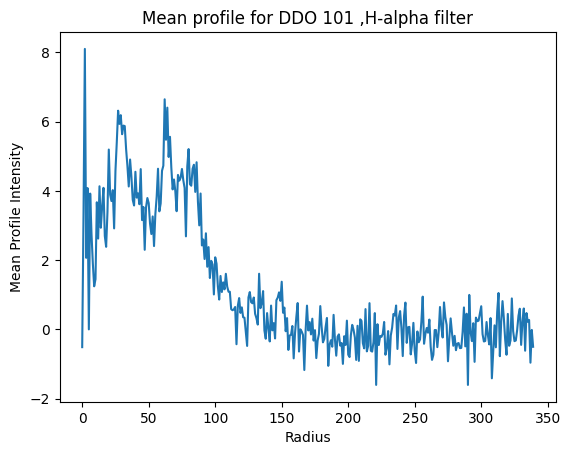

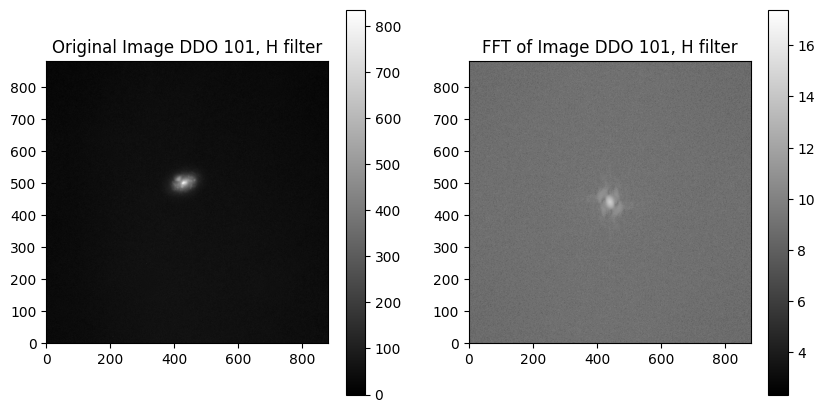

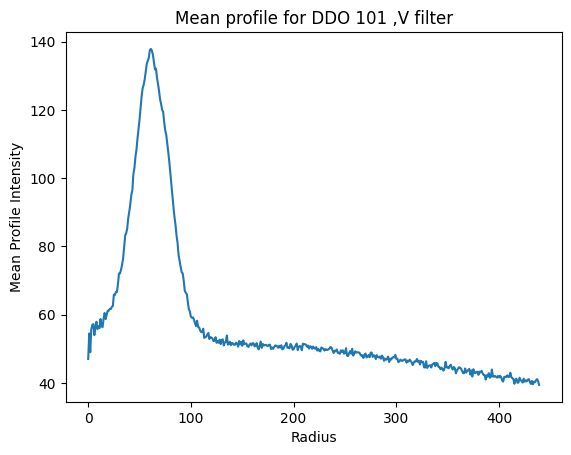

In [4]:
def compute_fft(image):
    fft_image = fft2(image)
    fft_image_shifted = fftshift(fft_image)
    return fft_image_shifted

def plot_image_and_fft(image, fft_image_shifted, name, filter):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray', origin = "lower")
    plt.colorbar()
    plt.title(f'Original Image {name}, {filter} filter')
    plt.subplot(1, 2, 2)
    plt.imshow(np.log(np.abs(fft_image_shifted)), cmap='gray', origin = "lower")
    plt.colorbar()
    plt.title(f'FFT of Image {name}, {filter} filter')
    plt.show()

def get_line_profile(image, start_point, angle, length):
    x0, y0 = start_point
    angle_rad = np.deg2rad(angle)
    profile = []

    for r in range(length):
        x = int(x0 + r * np.cos(angle_rad))
        y = int(y0 + r * np.sin(angle_rad))

        if 0 <= x < image.shape[1] and 0 <= y < image.shape[0]:
            profile.append(image[y, x])
        else:
            profile.append(np.nan)

    return profile

def resolution(image, name, filter, num_theta):
    fft_image_shifted = compute_fft(image)
    plot_image_and_fft(image, fft_image_shifted, name, filter)
    length = int(np.min(image.shape) / 2)
    center = np.array(image.shape) // 2
    profiles = []
    
    for theta in np.linspace(0, 2 * np.pi, num=num_theta, endpoint=False):
        profile = get_line_profile(image, center, np.rad2deg(theta), length)
        profiles.append(profile)
    
    mean_profile = np.nanmean(profiles, axis=0)
    
    return profiles, mean_profile, length

def plot_profiles_on_image(image, profiles, num_theta):
    plt.imshow(image, cmap='gray', origin = "lower")
    center = np.array(image.shape) // 2
    length = profiles.shape[1]

    for i, theta in enumerate(np.linspace(0, 2 * np.pi, num=num_theta, endpoint=False)):
        x_offset = np.cos(theta)
        y_offset = np.sin(theta)

        x = [center[1] + r * x_offset for r in range(length)]
        y = [center[0] + r * y_offset for r in range(length)]

        plt.plot(x, y, label=f'Theta {np.rad2deg(theta):.1f}°')

    plt.title('Profiles on Image')
    plt.show()


image = DDO101_H_replaced
profiles, mean_profile, length = resolution(image, galaxy_name, "H", num_theta=360)
x_ax = np.arange(0, length)
plt.plot(x_ax, mean_profile)
plt.xlabel('Radius')
plt.ylabel('Mean Profile Intensity')
plt.title(f'Mean profile for {galaxy_name} ,H-alpha filter')
plt.show()

image = DDO101_V
profiles, mean_profile, length = resolution(image, galaxy_name, "H", num_theta=360)
x_ax = np.arange(0, length)
plt.plot(x_ax, mean_profile)
plt.xlabel('Radius')
plt.ylabel('Mean Profile Intensity')
plt.title(f'Mean profile for {galaxy_name} ,V filter')
plt.show()
#plot_profiles_on_image(image, np.array(profiles), num_theta=360)



# V and H-alpha overlay

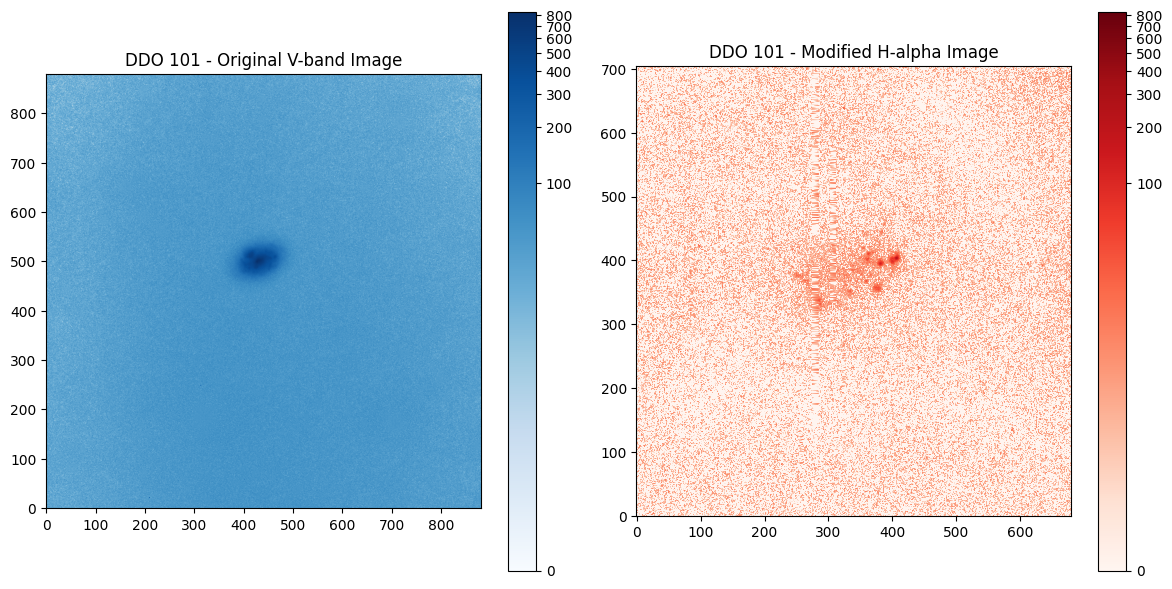

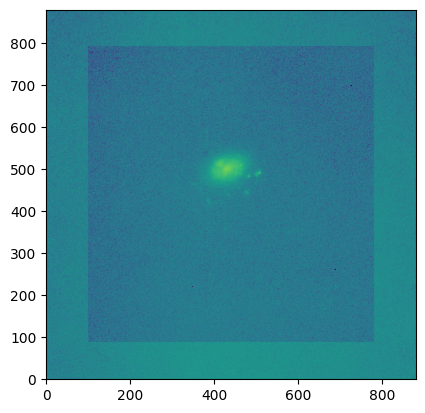

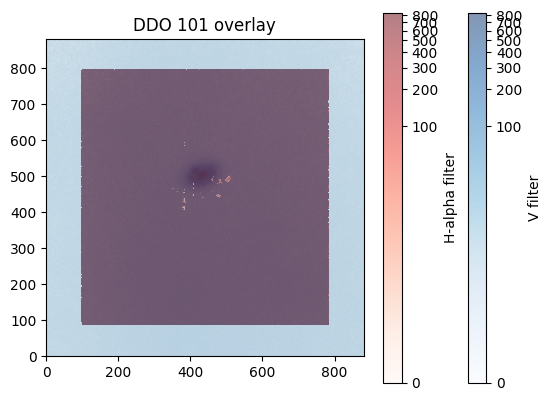

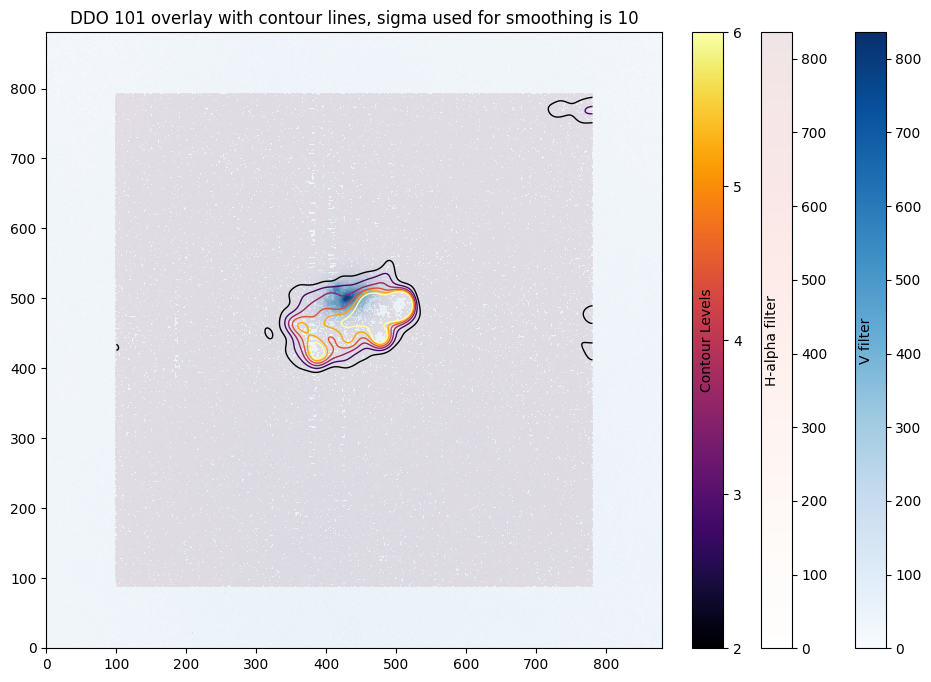

ratio of FITS 0.9659574468085106
ratio of FOVs 0.9657867315039944
x pixel scale 0.4899559471365638 , y pixel scale 0.49004255319148937
Resolution from NED 1.800e+0 arcsec


In [5]:
norm = ImageNormalize(vmin=0., stretch=LogStretch())

# Assume DDO101_H and DDO101_V are your image arrays
H_height, H_width = DDO101_H.shape
V_height, V_width = DDO101_V.shape

# Calculate the center positions
H_center_y, H_center_x = H_height // 2, H_width // 2
V_center_y, V_center_x = V_height // 2, V_width // 2

# Calculate offsets to align centers
y_offset = V_center_y - H_center_y
x_offset = V_center_x - H_center_x


# Assume DDO101_H and DDO101_V are your image arrays
H_height, H_width = DDO101_H_replaced.shape
V_height, V_width = DDO101_V.shape

# Plot both images side by side to scale
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the larger image (DDO101_V)
im_v = axes[0].imshow(DDO101_V, cmap='Blues', origin='lower', norm=norm)
axes[0].set_title(f"{galaxy_name} - Original V-band Image")
axes[0].axis('on')
axes[0].set_aspect('equal')

# Add color bar for the larger image
fig.colorbar(im_v, ax=axes[0])

# Plot the smaller image (DDO101_H)
im_h = axes[1].imshow(DDO101_H_replaced, cmap='Reds', origin='lower', norm=norm)
axes[1].set_title(f"{galaxy_name} - Modified H-alpha Image")
axes[1].axis('on')
axes[1].set_aspect('equal')

# Add color bar for the smaller image
fig.colorbar(im_h, ax=axes[1])

plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
# Show the bigger image
#ax.imshow(DDO101_V, cmap='Blues', origin='lower', alpha=0.5, norm = norm)
overlay = DDO101_V * 0.5
overlay[y_offset:y_offset + H_height, x_offset:x_offset + H_width] = 0.5*(overlay[y_offset:y_offset + H_height, x_offset:x_offset + H_width]) + 0.5*(DDO101_H_replaced)
plt.imshow(overlay, origin = "lower", norm = norm)
plt.show()

fig, ax = plt.subplots()
ax.imshow(DDO101_V, cmap='Blues', origin='lower', alpha=0.5, norm = norm)
overlay = np.zeros_like(DDO101_V)
overlay[y_offset:y_offset + H_height, x_offset:x_offset + H_width] = DDO101_H_replaced
im1 = ax.imshow(DDO101_V, cmap='Blues', origin='lower', alpha=0.5, norm = norm)
im2 = ax.imshow(overlay, cmap='Reds', origin='lower', alpha=0.5, norm=norm)
cbar1 = plt.colorbar(im1, ax=ax)
cbar2 = plt.colorbar(im2, ax=ax)
cbar1.set_label("V filter")
cbar2.set_label("H-alpha filter")
plt.title(f"{galaxy_name} overlay")
plt.show()

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from matplotlib.colors import Normalize
import matplotlib.cm as cm

norm = Normalize(vmin=2, vmax=6) 

# Define sigma for smoothing
sigma = 10

# Assuming DDO101_H_replaced and DDO101_V are already defined
smoothed = gaussian_filter(DDO101_H_replaced, sigma)

# Get image shapes
H_height, H_width = DDO101_H_replaced.shape
V_height, V_width = DDO101_V.shape

# Calculate the center positions
H_center_y, H_center_x = H_height // 2, H_width // 2
V_center_y, V_center_x = V_height // 2, V_width // 2

# Calculate offsets to align centers
y_offset = V_center_y - H_center_y
x_offset = V_center_x - H_center_x

# Create the overlay plot with a larger figure size
fig, ax = plt.subplots(figsize=(12, 8))

overlay = np.zeros_like(DDO101_V)
overlay[y_offset:y_offset + H_height, x_offset:x_offset + H_width] = DDO101_H_replaced

# Adjust the normalization to ensure visibility of both datasets
norm = Normalize(vmin=np.min(DDO101_V), vmax=np.max(DDO101_V))

im1 = ax.imshow(DDO101_V, cmap='Blues', origin='lower', alpha=1, norm=norm)
im2 = ax.imshow(overlay, cmap='Reds', origin='lower', alpha=0.1, norm=norm)

# Add colorbars with a smaller size
cbar1 = plt.colorbar(im1, ax=ax, fraction=0.046, pad=0.06)
cbar2 = plt.colorbar(im2, ax=ax, fraction=0.046, pad=0.04)

cbar1.set_label("V filter", labelpad=-45)
cbar2.set_label("H-alpha filter", labelpad=-45)

# Add contours of the smoothed image
levels = [2, 3, 4, 5, 6, 7]
CS = ax.contour(smoothed, levels, cmap='inferno',
                linewidths=1,
                extent=(x_offset, x_offset + H_width, y_offset, y_offset + H_height))

# Custom color bar for contours
norm = Normalize(vmin=2, vmax=6)
sm = cm.ScalarMappable(cmap='inferno', norm=norm)
sm.set_array([])
cbar_contour = fig.colorbar(sm, ax=ax, ticks=levels, fraction=0.046, pad=0.04)
cbar_contour.ax.set_yticklabels([str(level) for level in levels])
cbar_contour.set_label('Contour Levels', labelpad=-30)

# Add title
plt.title(f"{galaxy_name} overlay with contour lines, sigma used for smoothing is {sigma}")
plt.show()

shape = np.shape(DDO101_H_replaced)
x = shape[1]
y = shape[0]
FOV_1_arcmin = 5.561e+0
FOV_1_arcsec = 5.561e+0 * 60
pixelscale_x = FOV_1_arcsec / x
FOV_2_arcmin = 5.758e+0
FOV_2_arcsec = 5.758e+0 * 60
pixelscale_y = FOV_2_arcsec / y

print("ratio of FITS", x / y)
print("ratio of FOVs", FOV_1_arcmin/FOV_2_arcmin)
print("x pixel scale", pixelscale_x ,", y pixel scale", pixelscale_y)
print("Resolution from NED 1.800e+0 arcsec")



# DDO 126

(616, 631)


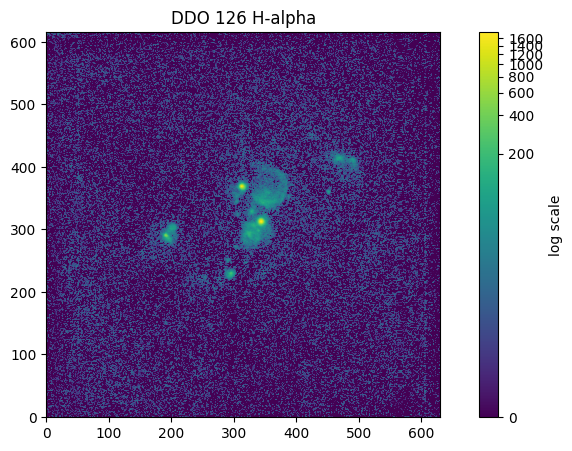

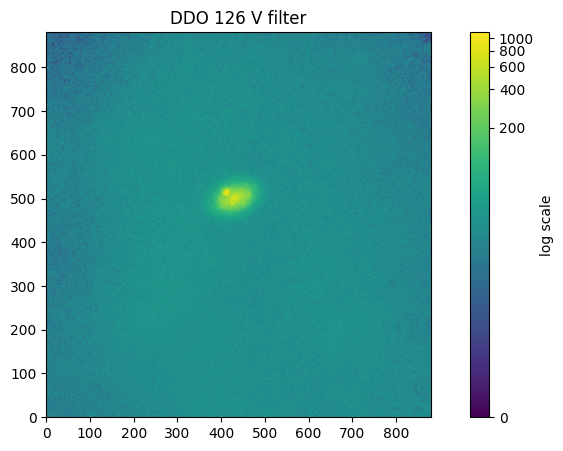

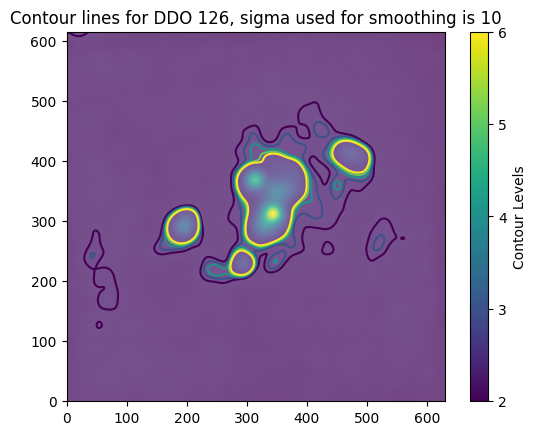

In [75]:
galaxy_name = "DDO 126"
DDO126_H = ltf.open_fits(r"C:\Users\AYSAN\Desktop\project\Galaxy\Data\DDO 126\d126hmrms.fits")
DDO126_V = ltf.open_fits(r"C:\Users\AYSAN\Desktop\project\Galaxy\Code\d126\starless\starless_DDO126_V_background_subtracted.fit")
print(np.shape(DDO126_H))
ltf.log_scale_plot(DDO126_H, "DDO 126 H-alpha", "log scale")
ltf.log_scale_plot(DDO101_V, "DDO 126 V filter", "log scale")

sigma = 10

# Assuming DDO101_H_replaced is already defined
smoothed = gaussian_filter(DDO126_H, sigma)

fig, ax = plt.subplots()
im = ax.imshow(smoothed, alpha=0.75, origin="lower")

# Create the contour plot
levels = [2, 3, 4, 5, 6]
CS = ax.contour(smoothed, levels, cmap='viridis')

# Create a custom color bar for the contour lines
norm = Normalize(vmin=2, vmax=6)  # Adjust this range according to your contour levels
sm = cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])

# Add the color bar with labels
cbar = fig.colorbar(sm, ax=ax, ticks=levels)
cbar.ax.set_yticklabels([str(level) for level in levels])
cbar.set_label('Contour Levels')

plt.title(f"Contour lines for {galaxy_name}, sigma used for smoothing is {sigma}")
plt.show()

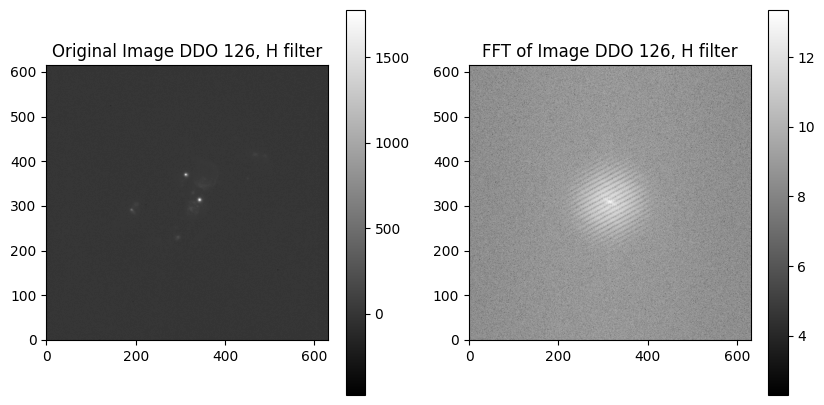

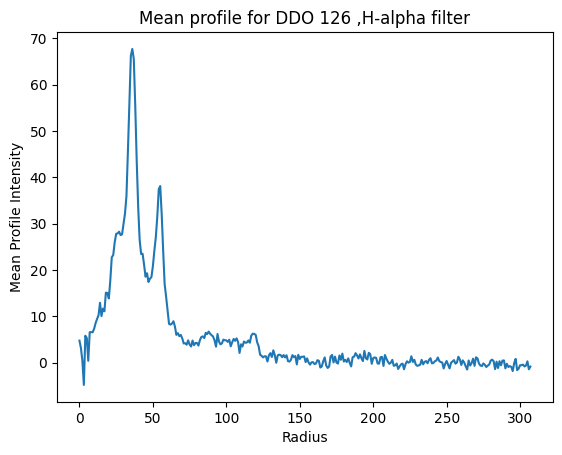

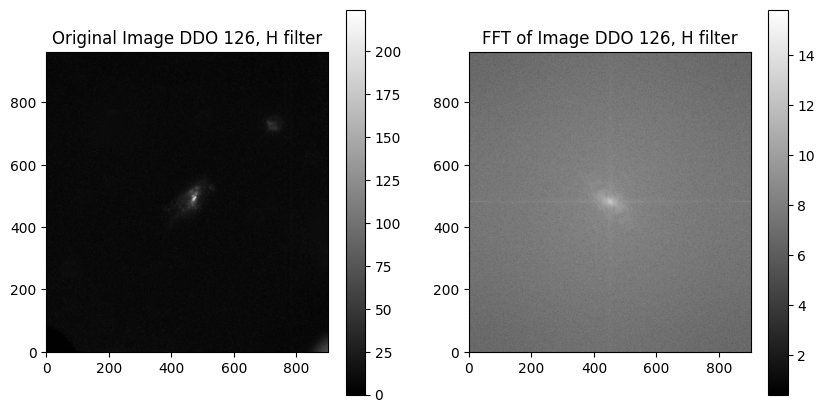

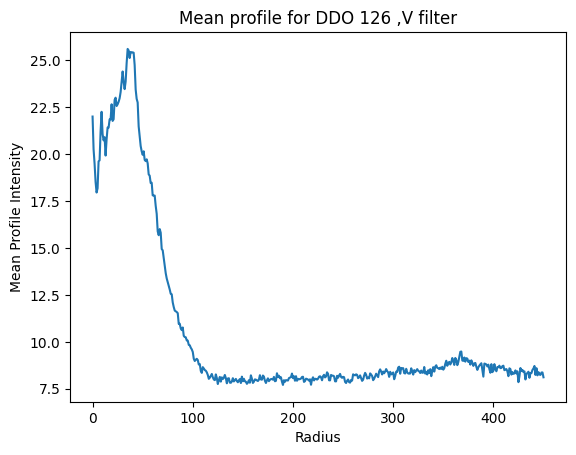

In [77]:
image = DDO126_H
profiles, mean_profile, length = resolution(image, galaxy_name, "H", num_theta=360)
x_ax = np.arange(0, length)
plt.plot(x_ax, mean_profile)
plt.xlabel('Radius')
plt.ylabel('Mean Profile Intensity')
plt.title(f'Mean profile for {galaxy_name} ,H-alpha filter')
plt.show()

image = DDO126_V
profiles, mean_profile, length = resolution(image, galaxy_name, "H", num_theta=360)
x_ax = np.arange(0, length)
plt.plot(x_ax, mean_profile)
plt.xlabel('Radius')
plt.ylabel('Mean Profile Intensity')
plt.title(f'Mean profile for {galaxy_name} ,V filter')
plt.show()
#plot_profiles_on_image(image, np.array(profiles), num_theta=360)

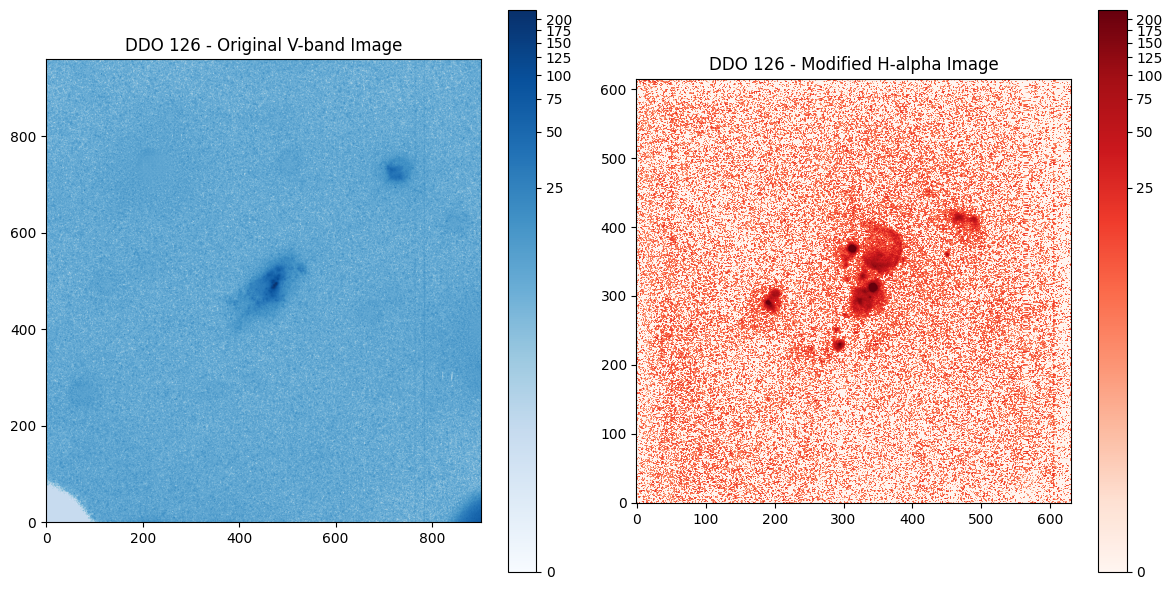

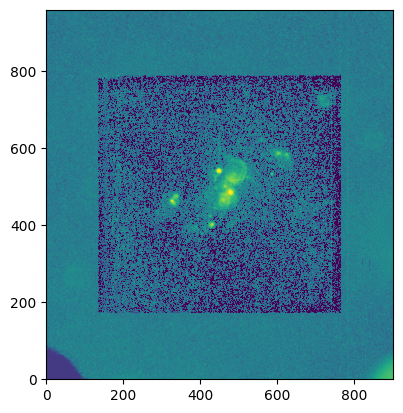

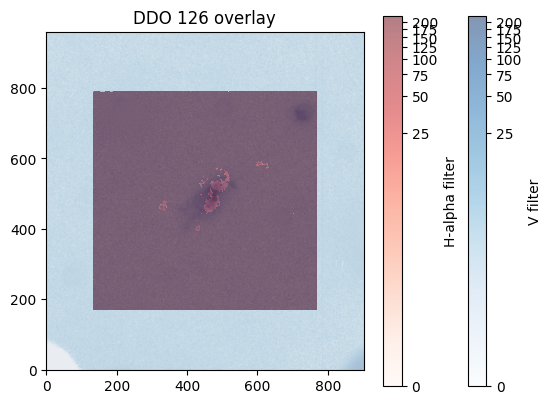

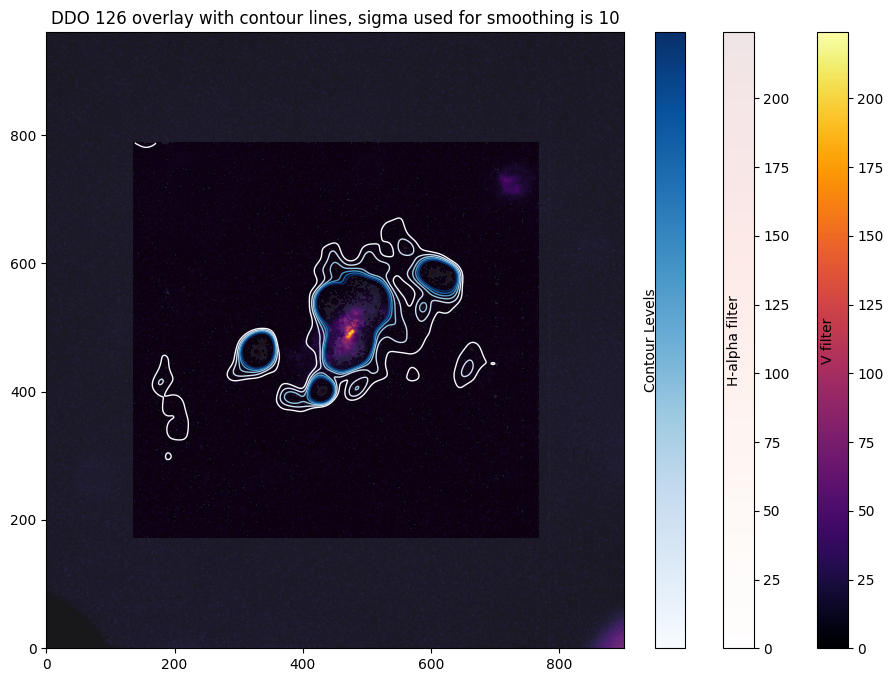

'\nshape = np.shape(DDO126_H)\nx = shape[1]\ny = shape[0]\nFOV_1_arcmin = 5.561e+0\nFOV_1_arcsec = 5.561e+0 * 60\npixelscale_x = FOV_1_arcsec / x\nFOV_2_arcmin = 5.758e+0\nFOV_2_arcsec = 5.758e+0 * 60\npixelscale_y = FOV_2_arcsec / y\n\nprint("ratio of FITS", x / y)\nprint("ratio of FOVs", FOV_1_arcmin/FOV_2_arcmin)\nprint("x pixel scale", pixelscale_x ,", y pixel scale", pixelscale_y)\nprint("Resolution from NED 1.800e+0 arcsec")\n'

In [76]:
norm = ImageNormalize(vmin=0., stretch=LogStretch())

# Assume DDO101_H and DDO101_V are your image arrays
H_height, H_width = DDO126_H.shape
V_height, V_width = DDO126_V.shape

# Calculate the center positions
H_center_y, H_center_x = H_height // 2, H_width // 2
V_center_y, V_center_x = V_height // 2, V_width // 2

# Calculate offsets to align centers
y_offset = V_center_y - H_center_y
x_offset = V_center_x - H_center_x


# Assume DDO101_H and DDO101_V are your image arrays
H_height, H_width = DDO126_H.shape
V_height, V_width = DDO126_V.shape

# Plot both images side by side to scale
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the larger image (DDO101_V)
im_v = axes[0].imshow(DDO126_V, cmap='Blues', origin='lower', norm=norm)
axes[0].set_title(f"{galaxy_name} - Original V-band Image")
axes[0].axis('on')
axes[0].set_aspect('equal')

# Add color bar for the larger image
fig.colorbar(im_v, ax=axes[0])

# Plot the smaller image (DDO101_H)
im_h = axes[1].imshow(DDO126_H, cmap='Reds', origin='lower', norm=norm)
axes[1].set_title(f"{galaxy_name} - Modified H-alpha Image")
axes[1].axis('on')
axes[1].set_aspect('equal')

# Add color bar for the smaller image
fig.colorbar(im_h, ax=axes[1])

plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
# Show the bigger image
#ax.imshow(DDO101_V, cmap='Blues', origin='lower', alpha=0.5, norm = norm)
overlay = DDO126_V * 0.5
overlay[y_offset:y_offset + H_height, x_offset:x_offset + H_width] = 0.5*(overlay[y_offset:y_offset + H_height, x_offset:x_offset + H_width]) + 0.5*(DDO126_H)
plt.imshow(overlay, origin = "lower", norm = norm)
plt.show()

fig, ax = plt.subplots()
ax.imshow(DDO126_V, cmap='Blues', origin='lower', alpha=0.5, norm = norm)
overlay = np.zeros_like(DDO126_V)
overlay[y_offset:y_offset + H_height, x_offset:x_offset + H_width] = DDO126_H
im1 = ax.imshow(DDO126_V, cmap='Blues', origin='lower', alpha=0.5, norm = norm)
im2 = ax.imshow(overlay, cmap='Reds', origin='lower', alpha=0.5, norm=norm)
cbar1 = plt.colorbar(im1, ax=ax)
cbar2 = plt.colorbar(im2, ax=ax)
cbar1.set_label("V filter")
cbar2.set_label("H-alpha filter")
plt.title(f"{galaxy_name} overlay")
plt.show()

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from matplotlib.colors import Normalize
import matplotlib.cm as cm

norm = Normalize(vmin=2, vmax=6) 

# Define sigma for smoothing
sigma = 10

# Assuming DDO101_H_replaced and DDO126_V are already defined
smoothed = gaussian_filter(DDO126_H, sigma)

# Get image shapes
H_height, H_width = DDO126_H.shape
V_height, V_width = DDO126_V.shape

# Calculate the center positions
H_center_y, H_center_x = H_height // 2, H_width // 2
V_center_y, V_center_x = V_height // 2, V_width // 2

# Calculate offsets to align centers
y_offset = V_center_y - H_center_y
x_offset = V_center_x - H_center_x

# Create the overlay plot with a larger figure size
fig, ax = plt.subplots(figsize=(12, 8))

overlay = np.zeros_like(DDO126_V)
overlay[y_offset:y_offset + H_height, x_offset:x_offset + H_width] = DDO126_H

# Adjust the normalization to ensure visibility of both datasets
norm = Normalize(vmin=np.min(DDO126_V), vmax=np.max(DDO126_V))

im1 = ax.imshow(DDO126_V, cmap='inferno', origin='lower', alpha=1, norm=norm)
im2 = ax.imshow(overlay, cmap='Reds', origin='lower', alpha=0.1, norm=norm)

# Add colorbars with a smaller size
cbar1 = plt.colorbar(im1, ax=ax, fraction=0.046, pad=0.06)
cbar2 = plt.colorbar(im2, ax=ax, fraction=0.046, pad=0.04)

cbar1.set_label("V filter", labelpad=-45)
cbar2.set_label("H-alpha filter", labelpad=-45)

# Add contours of the smoothed image
levels = [2, 3, 4, 5, 6, 7]
CS = ax.contour(smoothed, levels, cmap='Blues',
                linewidths=1,
                extent=(x_offset, x_offset + H_width, y_offset, y_offset + H_height))

# Custom color bar for contours
norm = Normalize(vmin=2, vmax=6)
sm = cm.ScalarMappable(cmap='Blues')
sm.set_array([])
cbar_contour = fig.colorbar(sm, ax=ax, ticks=levels, fraction=0.046, pad=0.04)
cbar_contour.ax.set_yticklabels([str(level) for level in levels])
cbar_contour.set_label('Contour Levels', labelpad=-30)

# Add title
plt.title(f"{galaxy_name} overlay with contour lines, sigma used for smoothing is {sigma}")
plt.show()

#H_alpha
# RA      = '11:52:00.60'         /  right ascension (telescope)                  
# DEC     = '31:54:18.00'


'''
shape = np.shape(DDO126_H)
x = shape[1]
y = shape[0]
FOV_1_arcmin = 5.561e+0
FOV_1_arcsec = 5.561e+0 * 60
pixelscale_x = FOV_1_arcsec / x
FOV_2_arcmin = 5.758e+0
FOV_2_arcsec = 5.758e+0 * 60
pixelscale_y = FOV_2_arcsec / y

print("ratio of FITS", x / y)
print("ratio of FOVs", FOV_1_arcmin/FOV_2_arcmin)
print("x pixel scale", pixelscale_x ,", y pixel scale", pixelscale_y)
print("Resolution from NED 1.800e+0 arcsec")
'''